In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [2]:
train = pd.read_csv('Train_SU63ISt.csv')
test = pd.read_csv('Test_0qrQsBZ.csv')

In [3]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [5]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train['hour'] = train.Datetime.dt.hour

In [6]:
train.head()

,ID,Datetime,Count,hour
0,0,2012-08-25 00:00:00,8,0
1,1,2012-08-25 01:00:00,2,1
2,2,2012-08-25 02:00:00,6,2
3,3,2012-08-25 03:00:00,2,3
4,4,2012-08-25 04:00:00,2,4


In [7]:
# Calculate average hourly fraction
hourly_frac = train.groupby(['hour']).mean()/np.sum(train.groupby(['hour']).mean())
hourly_frac.drop(['ID'], axis = 1, inplace = True)
hourly_frac.columns = ['fraction']

In [8]:
# Convert to time series from dataframe
train.index = train.Datetime
train.drop(['ID', 'hour', 'Datetime'], axis = 1, inplace = True)

In [9]:
train.head()

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [10]:
daily_train = train.resample('D').sum()

In [11]:
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train.Count
daily_train.drop(['Count'], axis = 1, inplace = True)

In [12]:
# Fitting the model
model = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1) # seasonality_prior_scale - Parameter for changing strength of seasonality model
model.fit(daily_train)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/vipul/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [13]:
predict_df = model.make_future_dataframe(periods = 213)
forecast = model.predict(predict_df)

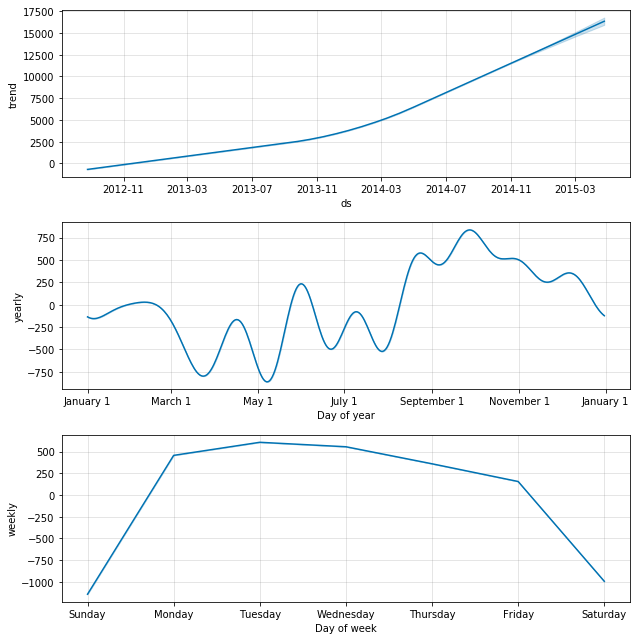

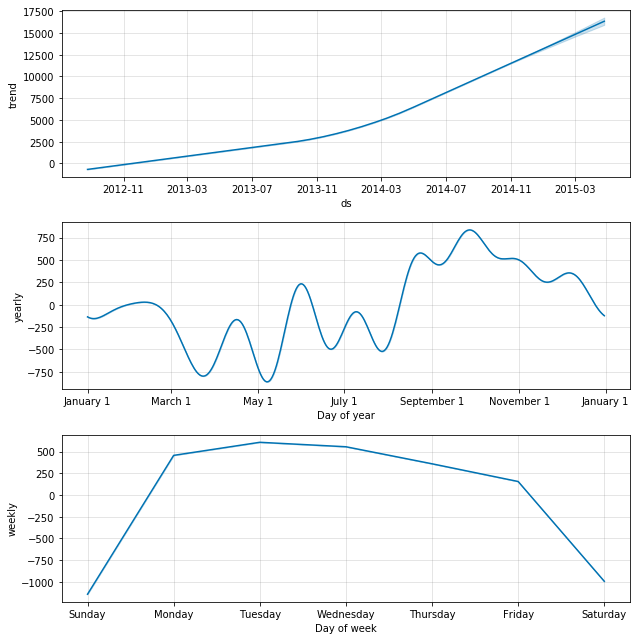

In [14]:
model.plot_components(forecast)

In [15]:
forecast['Datetime'] = forecast.ds
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat,Datetime
0,2012-08-25,-683.883579,-683.883579,-683.883579,-2299.169520,42.028488,-422.120847,-422.120847,-422.120847,0.0,0.0,0.0,-994.402080,-994.402080,-994.402080,572.281232,572.281232,572.281232,-1106.004426,2012-08-25
1,2012-08-26,-675.796037,-675.796037,-675.796037,-2476.413125,-65.919069,-580.128395,-580.128395,-580.128395,0.0,0.0,0.0,-1143.347054,-1143.347054,-1143.347054,563.218658,563.218658,563.218658,-1255.924432,2012-08-26
2,2012-08-27,-667.708495,-667.708495,-667.708495,-845.867708,1572.724325,1008.525224,1008.525224,1008.525224,0.0,0.0,0.0,457.225419,457.225419,457.225419,551.299806,551.299806,551.299806,340.816729,2012-08-27
3,2012-08-28,-659.620953,-659.620953,-659.620953,-750.445956,1615.250023,1145.233597,1145.233597,1145.233597,0.0,0.0,0.0,607.897821,607.897821,607.897821,537.335777,537.335777,537.335777,485.612644,2012-08-28
4,2012-08-29,-651.533412,-651.533412,-651.533412,-741.185164,1700.478272,1078.640469,1078.640469,1078.640469,0.0,0.0,0.0,556.483988,556.483988,556.483988,522.156480,522.156480,522.156480,427.107057,2012-08-29


In [18]:
# Extract hour, day, month and year from both dataframes to merge
for df in [test, forecast]:
    df['hour'] = df.Datetime.dt.hour
    df['day'] = df.Datetime.dt.day
    df['month'] = df.Datetime.dt.month
    df['year'] = df.Datetime.dt.year

In [23]:
# Merge forecasts with given IDs
test = pd.merge(test, forecast, on = ['hour', 'day', 'month', 'year'], how = 'left')
cols = ['ID', 'hour', 'yhat']
test_new = test[cols]

In [25]:
# Merging hourly average fraction to the test data
test_new = pd.merge(test_new, hourly_frac, left_on = ['hour'], right_index = True, how = 'left')

In [27]:
test_new['Count'] = test_new['yhat'] * test_new['fraction']

In [29]:
test_new.drop(['yhat','fraction','hour'],axis = 1, inplace = True)

In [31]:
test_new.head()

,ID,Count
0,18288,509.673014
1,18289,NaN
2,18290,NaN
3,18291,NaN
4,18292,NaN
